# **MSE 981 Final Project**
# **Movie Recommendation System with Neural Network**

All the discussions, explanations and conclusions are added in the report

# **1. Data Cleaning and Preprocessing:**

In [ ]:
#importing the libraries

!pip install -q scikit-learn

!pip install -q tensorflow



import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import math
import itertools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dropout, dot, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot


from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Input, dot, concatenate

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.neighbors import NearestNeighbors
from keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading dataset

rates = pd.read_csv('/content/drive/MyDrive/MSE 981 /Final Project/ratings.csv')

# we do not care when the user rated the particular movie!
print('Table of rates : (rows, features): ',rates.shape)
movies =pd.read_csv('/content/drive/MyDrive/MSE 981 /Final Project/movies.csv')
print('Table of movies : (rows, features): ',movies.shape)
rates.head()


Table of rates : (rows, features):  (1048575, 3)
Table of movies : (rows, features):  (62423, 3)


,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [ ]:
# Check for missing values in the rates DataFrame
missing_values_rates = rates.isnull().sum()
print("Missing values in rates DataFrame:")
print(missing_values_rates)

# Check for missing values in the movies DataFrame
missing_values_movies = movies.isnull().sum()
print("Missing values in movies DataFrame:")
print(missing_values_movies)

Missing values in rates DataFrame:
userId     0
movieId    0
rating     0
dtype: int64
Missing values in movies DataFrame:
movieId    0
title      0
genres     0
dtype: int64


# **2. Exploratory Data Analysis (EDA):**

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:

users = rates.userId.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
Movies = rates.movieId.unique()
movie_map = {i:val for i,val in enumerate(Movies)}
inverse_movie_map = {val:i for i,val in enumerate(Movies)}

print("We have %d users"%users.shape[0])
print("We have %d movies"%Movies.shape[0])

We have 7045 users
We have 22240 movies


In [ ]:
rates.describe()

,userId,movieId,rating
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.575093e+03,2.119202e+04,3.535808e+00
std,2.016420e+03,3.911993e+04,1.056276e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,1.843000e+03,1.148000e+03,3.000000e+00
50%,3.609000e+03,2.858000e+03,3.500000e+00
75%,5.322000e+03,8.464000e+03,4.000000e+00
max,7.045000e+03,2.091630e+05,5.000000e+00


In [ ]:

ratings_df = rates.groupby(['userId','movieId']).aggregate(np.max)
print(len(ratings_df))
if (len(ratings_df) == rates.shape[0]):
  print("there are no such cases where the user has rated the same movie twice.")


1048575
there are no such cases where the user has rated the same movie twice.


<Axes: xlabel='rating'>

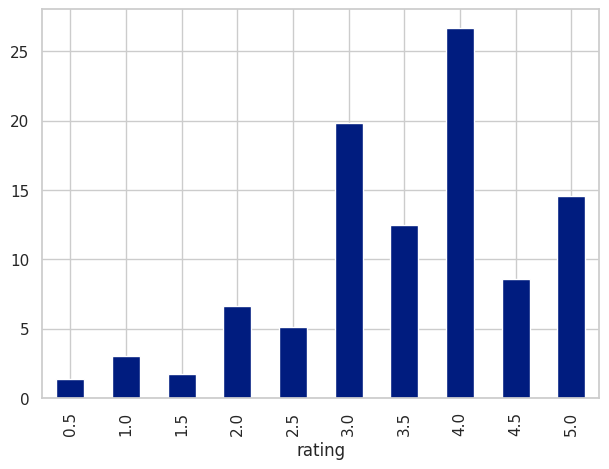

In [ ]:

count_rates = rates.groupby('rating').count()
count_rates['perc_total']=round(count_rates['userId']*100/count_rates['userId'].sum(),1)
count_rates['perc_total'].plot.bar()

# **3. Clustering Users:**

In [ ]:
#Merge movies metadata and ratings data on movieId.

ratedmovies = pd.merge(rates, movies, on = 'movieId')
ratedmovies.tail()


,userId,movieId,rating,title,genres
1048570,7036,150858,2.5,Cougar Hunting (2011),Comedy|Romance
1048571,7036,166480,3.0,Eliminators (2016),Action|Thriller
1048572,7036,188931,3.5,Birdsong (2012),Drama|War
1048573,7036,203799,1.0,Cold Blood (2019),Action|Thriller
1048574,7036,207023,2.5,10 Minutes Gone (2019),Action|Crime|Mystery|Thriller


In [ ]:
uni= ratedmovies.movieId.unique()
print("We have %d movies"%uni.shape[0])

We have 22240 movies


In [ ]:
# Drop non-numerical features and standardize data

data = ratedmovies.drop(['title', 'genres'], axis=1)
display(data.head())
print()
print()


# Standardize the data
scaler = StandardScaler()
data_std = scaler.fit_transform(data)
print("Standardized Data:")
print(data_std)


# Suppress FutureWarning for n_init
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Perform K-means clustering
    num_clusters = 5  # You can choose the number of clusters based on your dataset.
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    data['user_cluster'] = kmeans.fit_predict(data_std)

# Print the user clusters stats
print()
print()
print("\nUser Clusters Stats:")
user_clusters_stats = data.groupby('user_cluster').mean()
print(user_clusters_stats)


,userId,movieId,rating
0,1,296,5.0
1,3,296,5.0
2,4,296,4.0
3,5,296,4.0
4,7,296,4.0




Standardized Data:
[[-1.77249531 -0.53415307  1.38618411]
 [-1.77150345 -0.53415307  1.38618411]
 [-1.77100752 -0.53415307  0.43946112]
 ...
 [ 1.71636305  4.28781624 -0.03390037]
 [ 1.71636305  4.66787847 -2.40070783]
 [ 1.71636305  4.75029175 -0.98062335]]



User Clusters Stats:
                   userId        movieId    rating
user_cluster                                      
0             3603.199118  109037.542623  3.602622
1             5338.726888    8057.923929  4.220521
2             1800.928885    8067.977761  2.419818
3             5308.465413    8302.924180  2.423259
4             1787.636717    7924.643197  4.222825


In [ ]:
# Analyze the user segments further
# For example, you can check the average rating for each user cluster
average_rating_by_cluster = user_clusters_stats['rating']
print("\nAverage Rating by User Cluster:")
print(average_rating_by_cluster)



Average Rating by User Cluster:
user_cluster
0    3.602622
1    4.220521
2    2.419818
3    2.423259
4    4.222825
Name: rating, dtype: float64


# **4. Data Visualization:**

**Genres Distribution:**

In [ ]:

# Create a function to find genres in the dataset
genres = {}
def find_genres():
  for genre in movies['genres']:
    words = genre.split('|')
    for word in words:
      genres[word] = genres.get(word, 0) + 1

find_genres()
genres['None'] = genres.pop('(no genres listed)')
listofgenres = list(genres.keys())
genres

{'Adventure': 4145,
 'Animation': 2929,
 'Children': 2935,
 'Comedy': 16870,
 'Fantasy': 2731,
 'Romance': 7719,
 'Drama': 25606,
 'Action': 7348,
 'Crime': 5319,
 'Thriller': 8654,
 'Horror': 5989,
 'Mystery': 2925,
 'Sci-Fi': 3595,
 'IMAX': 195,
 'Documentary': 5605,
 'War': 1874,
 'Musical': 1054,
 'Western': 1399,
 'Film-Noir': 353,
 'None': 5062}

**List of top scored movies over the whole range of movies, Using Weighted_Score**

In [ ]:

# GENRES = movies['genres']
MoviesWithGenres = movies.copy()
for genre in listofgenres :
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis = 1)
display(MoviesWithGenres.head())

avg_movie_rating = pd.DataFrame(rates.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index
avg_rating_all= rates['rating'].mean()
min_reviews=20
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.index.name = None

def weighted_rating(x, m=min_reviews, C=avg_rating_all):
  v = x['count']
  R = x['mean']
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)

movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
# movie_score.head()
movie_score = pd.merge(movie_score,MoviesWithGenres,on='movieId')
# movie_score.head()
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])





,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,None
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<ipython-input-28-a57da0dfe9a8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)


,title,count,mean,weighted_score,genres
246,"Shawshank Redemption, The (1994)",3488,4.436067,4.430934,Crime|Drama
577,"Godfather, The (1972)",2175,4.354253,4.346796,Crime|Drama
5371,Band of Brothers (2001),69,4.565217,4.333889,Action|Drama|War
801,"Godfather: Part II, The (1974)",1415,4.313781,4.302938,Crime|Drama
46,"Usual Suspects, The (1995)",2393,4.309235,4.302825,Crime|Mystery|Thriller
412,Schindler's List (1993),2545,4.276031,4.270260,Drama|War
5374,Planet Earth II (2016),50,4.560000,4.267374,Documentary
775,One Flew Over the Cuckoo's Nest (1975),1504,4.236370,4.227176,Drama
1885,Fight Club (1999),2530,4.226285,4.220869,Action|Crime|Drama|Thriller
5299,Planet Earth (2006),83,4.385542,4.220545,Documentary


**Getting top n movies per genre:**

In [ ]:
def best_by_genre(genre,top_n):
  return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

best_by_genre('Drama',5)


,title,count,mean,weighted_score
246,"Shawshank Redemption, The (1994)",3488,4.436067,4.430934
577,"Godfather, The (1972)",2175,4.354253,4.346796
5371,Band of Brothers (2001),69,4.565217,4.333889
801,"Godfather: Part II, The (1974)",1415,4.313781,4.302938
412,Schindler's List (1993),2545,4.276031,4.270260


**Heavily Rated Movies**

In [ ]:

df_n_ratings = pd.DataFrame(ratedmovies.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(ratedmovies.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)




,mean ratings,total ratings
title,,
Forrest Gump (1994),4.057987,3518
"Shawshank Redemption, The (1994)",4.436067,3488
Pulp Fiction (1994),4.182417,3418
"Silence of the Lambs, The (1991)",4.131546,3227
"Matrix, The (1999)",4.160738,3064
Star Wars: Episode IV - A New Hope (1977),4.101160,2931
Jurassic Park (1993),3.687432,2745
Schindler's List (1993),4.276031,2545
Fight Club (1999),4.226285,2530


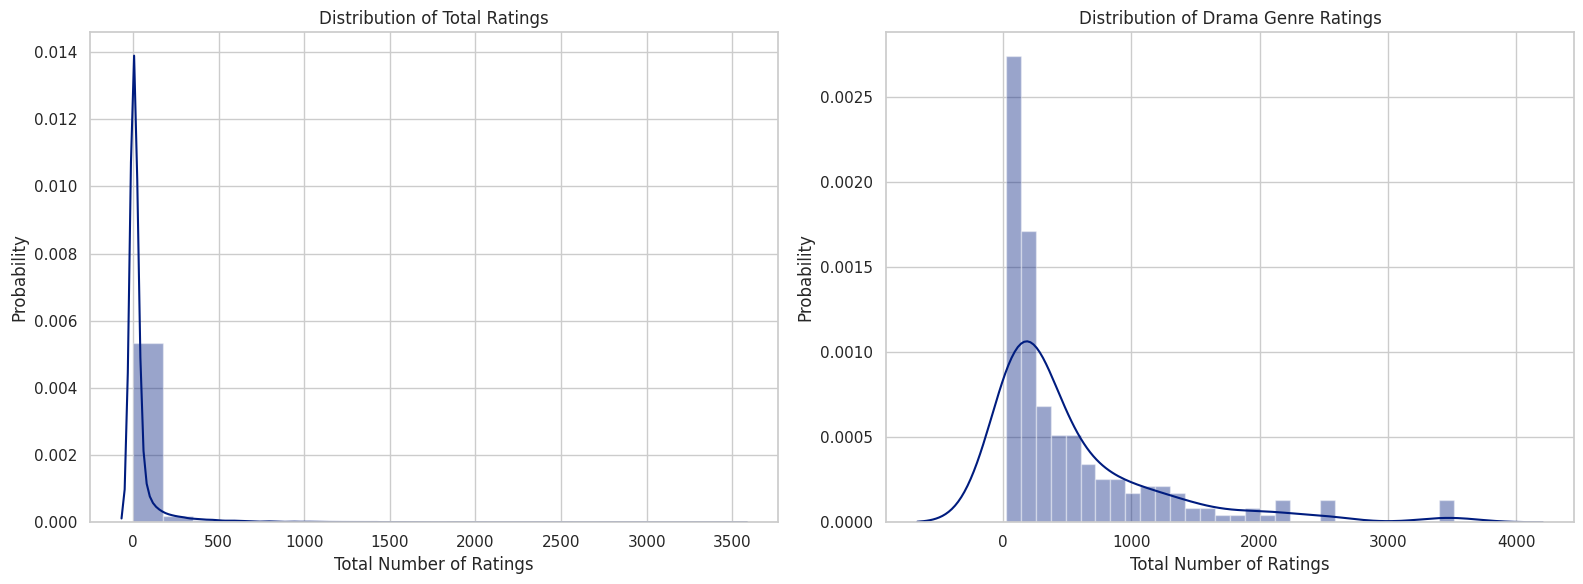

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Suppress UserWarnings for this specific code block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # First subplot
    sns.distplot(df_n_ratings['total ratings'], bins=20, ax=axes[0])
    axes[0].set_xlabel('Total Number of Ratings')
    axes[0].set_ylabel('Probability')
    axes[0].set_title('Distribution of Total Ratings')

    # Second subplot
    sns.distplot(best_by_genre('Drama', 200)['count'], bins=30, ax=axes[1])
    axes[1].set_xlabel('Total Number of Ratings')
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Distribution of Drama Genre Ratings')

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plot
plt.show()

**Mean ratings vs Total number of ratings**


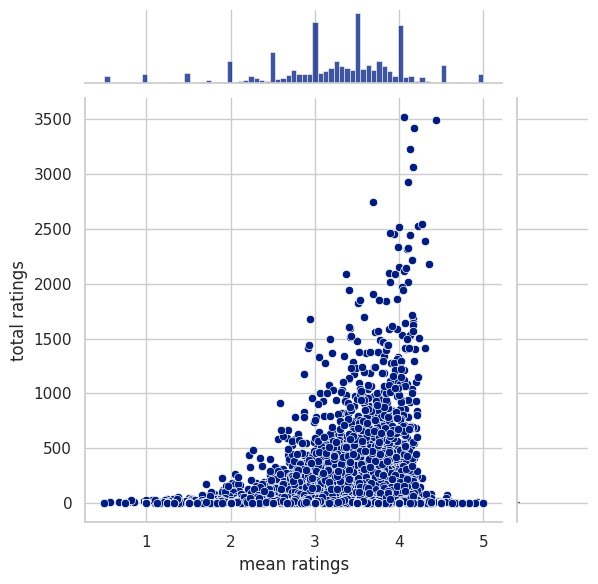

In [ ]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

# **5. Neural Network Modeling:** Model 1

In [ ]:
print('length of userid: ',len(ratedmovies.userId.unique()))
print('length of movieid: ',len(ratedmovies.movieId.unique()))
print('length of genres: ',len(ratedmovies.genres.unique()))


# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies and 0, no_of_genres respectively.
newratedmovies = ratedmovies.copy()
newratedmovies.userId = newratedmovies.userId.astype('category').cat.codes.values
newratedmovies.movieId = newratedmovies.movieId.astype('category').cat.codes.values
newratedmovies.genres = newratedmovies.genres.astype('category').cat.codes.values
train, test = train_test_split(newratedmovies, test_size=0.2)

print()
display(train.head())
print()
display(test.head())

print()
print('train: ',train.shape)
print('test: ',test.shape)


length of userid:  7045
length of movieid:  22240
length of genres:  1264



,userId,movieId,rating,title,genres
242721,743,4412,4.0,Rush Hour 2 (2001),228
377086,2700,18755,3.5,The Nice Guys (2016),1048
653394,5859,11436,3.5,(500) Days of Summer (2009),923
952479,5459,14189,3.5,Oz the Great and Powerful (2013),133
882476,3759,3064,5.0,Man Bites Dog (C'est arrivé près de chez vous)...,871


,userId,movieId,rating,title,genres
282709,1106,8809,3.0,Sin City (2005),317
204694,3929,1188,4.0,Chinatown (1974),1032
777937,4250,2704,1.0,Armour of God II: Operation Condor (Operation ...,51
178455,2176,431,3.0,Demolition Man (1993),157
698696,5909,3319,4.5,Caddyshack (1980),855



train:  (838860, 5)
test:  (209715, 5)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 10)        222410      ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 10)        70460       ['User[0][0]']                   
                                                                                              

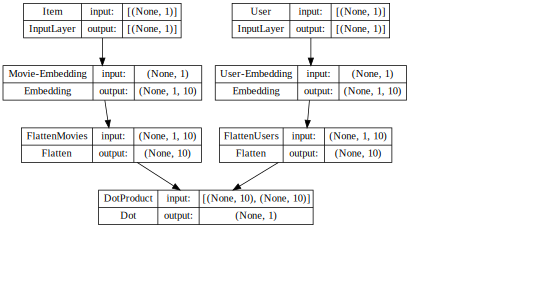

In [ ]:
n_users, n_movies, n_genres = len(newratedmovies.userId.unique()), len(newratedmovies.movieId.unique()), len(newratedmovies.genres.unique())
def matrix_factorisation_model_with_n_latent_factors(n_latent_factors, opt) :
  movie_input = keras.layers.Input(shape=(1,),name='Item',dtype='int64')
  movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

  user_input = keras.layers.Input(shape=(1,),name='User',dtype='int64')
  user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
  user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

  prod = dot([movie_vec, user_vec],name='DotProduct', axes = 1)

  model = keras.Model([user_input, movie_input], prod)
  model.compile(optimizer = opt , loss = 'mean_squared_error')

  return model


import keras
batch_size=128
epochs=30
TESTUSER = 200
n_latent_factors = 10
optimizer = Adam()
model = matrix_factorisation_model_with_n_latent_factors(n_latent_factors, optimizer)


# SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))




# **6. Model Performance Evaluation:** - Model 1

In [ ]:
from IPython.display import clear_output

callbacks = [EarlyStopping('val_loss', patience=2),
             ModelCheckpoint('bestweights.h5', save_best_only=True)]

History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([test.userId,test.movieId],test.rating),
                              verbose = 1, callbacks=callbacks)
# clear_output()

Train on 838860 samples, validate on 209715 samples
Epoch 1/30
837632/838860 [============================>.] - ETA: 0s - loss: 5.9985

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


838860/838860 [==============================] - 34s 40us/sample - loss: 5.9921 - val_loss: 1.7520
Epoch 2/30
838860/838860 [==============================] - 29s 35us/sample - loss: 1.2772 - val_loss: 1.0916
Epoch 3/30
838860/838860 [==============================] - 30s 36us/sample - loss: 0.9620 - val_loss: 0.9658
Epoch 4/30
838860/838860 [==============================] - 29s 35us/sample - loss: 0.8702 - val_loss: 0.9173
Epoch 5/30
838860/838860 [==============================] - 31s 37us/sample - loss: 0.8227 - val_loss: 0.8913
Epoch 6/30
838860/838860 [==============================] - 33s 39us/sample - loss: 0.7911 - val_loss: 0.8739
Epoch 7/30
838860/838860 [==============================] - 28s 33us/sample - loss: 0.7645 - val_loss: 0.8563
Epoch 8/30
838860/838860 [==============================] - 28s 33us/sample - loss: 0.7381 - val_loss: 0.8399
Epoch 9/30
838860/838860 [==============================] - 29s 35us/sample - loss: 0.7102 - val_loss: 0.8232
Epoch 10/30
838860/83

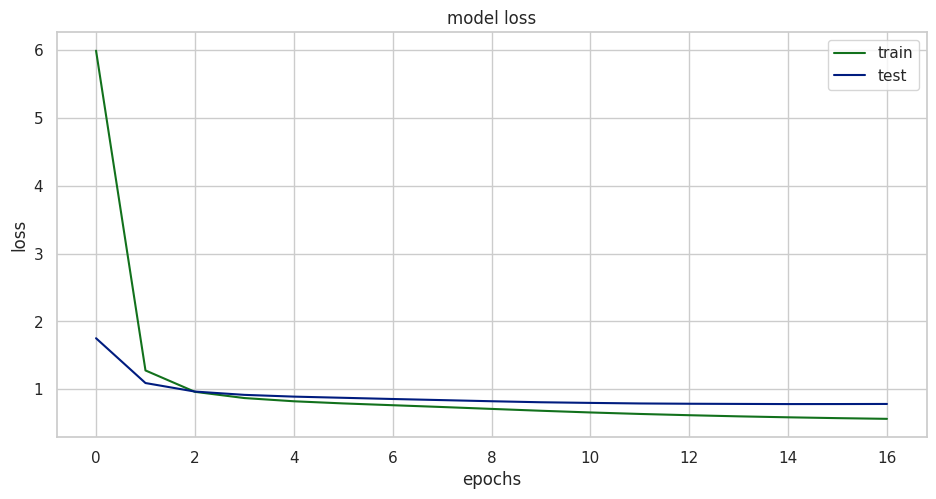

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()


In [ ]:

min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(History.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))



Minimum RMSE at epoch 15 = 0.8840


In [ ]:
# Use the pre-trained model
model = matrix_factorisation_model_with_n_latent_factors(n_latent_factors, optimizer)
# Load weights
model.load_weights('bestweights.h5')

# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
  return model.predict([np.array([user_id-1]), np.array([movie_id-1])])[0][0]

user_ratings = rates[rates['userId'] == TESTUSER][['userId', 'movieId', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TESTUSER, x['movieId']), axis=1)
user_ratings.sort_values(by='rating',
                         ascending=False).merge(movies,
                                                on='movieId',
                                                how='inner',
                                                suffixes=['_u', '_m']).head(20)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


,userId,movieId,rating,prediction,title,genres
0,200,648,5.0,5.640968,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
1,200,661,5.0,3.874794,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical
2,200,34,5.0,4.781625,Babe (1995),Children|Drama
3,200,62,5.0,4.716998,Mr. Holland's Opus (1995),Drama
4,200,260,5.0,4.904337,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,200,802,5.0,5.201446,Phenomenon (1996),Drama|Romance
6,200,356,5.0,5.427655,Forrest Gump (1994),Comedy|Drama|Romance|War
7,200,765,5.0,4.381344,Jack (1996),Comedy|Drama
8,200,736,5.0,4.277479,Twister (1996),Action|Adventure|Romance|Thriller
9,200,1073,4.0,5.268864,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical


In [ ]:

recommendations = rates[~rates['movieId'].isin(user_ratings['movieId']) == False][['movieId']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TESTUSER, x['movieId']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movieId',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movieId,prediction,title,genres
0,648,5.640968,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
1,356,5.427655,Forrest Gump (1994),Comedy|Drama|Romance|War
2,1073,5.268864,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
3,802,5.201446,Phenomenon (1996),Drama|Romance
4,260,4.904337,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,34,4.781625,Babe (1995),Children|Drama
6,62,4.716998,Mr. Holland's Opus (1995),Drama
7,1359,4.663666,Jingle All the Way (1996),Children|Comedy
8,480,4.662136,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
9,1,4.624478,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(user_ratings['rating'], user_ratings['prediction'])
mae = mean_absolute_error(user_ratings['rating'], user_ratings['prediction'])

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {math.sqrt(mse):.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")



Mean Squared Error (MSE): 0.7205
Root Mean Squared Error (RMSE): 0.8488
Mean Absolute Error (MAE): 0.7172
